# 1. Data Loading and Preprocessing:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import random
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [2]:
DATA_DIR = 'C:\\Users\\Khadi\\OneDrive\\chestxray\\chest_xray'
SUBDIRS = ['train', 'test', 'val']
CATEGORIES = ['PNEUMONIA', 'NORMAL']


In [3]:
print(os.listdir('C:\\Users\\Khadi\\OneDrive\\chestxray\\chest_xray'))


['chest_xray', 'test', 'train', 'val', '__MACOSX']


In [15]:
data = []

for subdir in SUBDIRS:
    for category in CATEGORIES:
        path = os.path.join(DATA_DIR, subdir, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                IMG_SIZE = 128  

                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
                



In [16]:
print(len(data))
print(data[0])


5856
[array([[19, 27, 30, ..., 16,  9,  2],
       [24, 26, 34, ..., 17, 11,  4],
       [22, 30, 39, ..., 19, 11,  4],
       ...,
       [10,  8,  7, ..., 15, 15, 15],
       [10,  8,  7, ..., 15, 15, 15],
       [10, 10,  7, ..., 15, 15, 15]], dtype=uint8), 0]


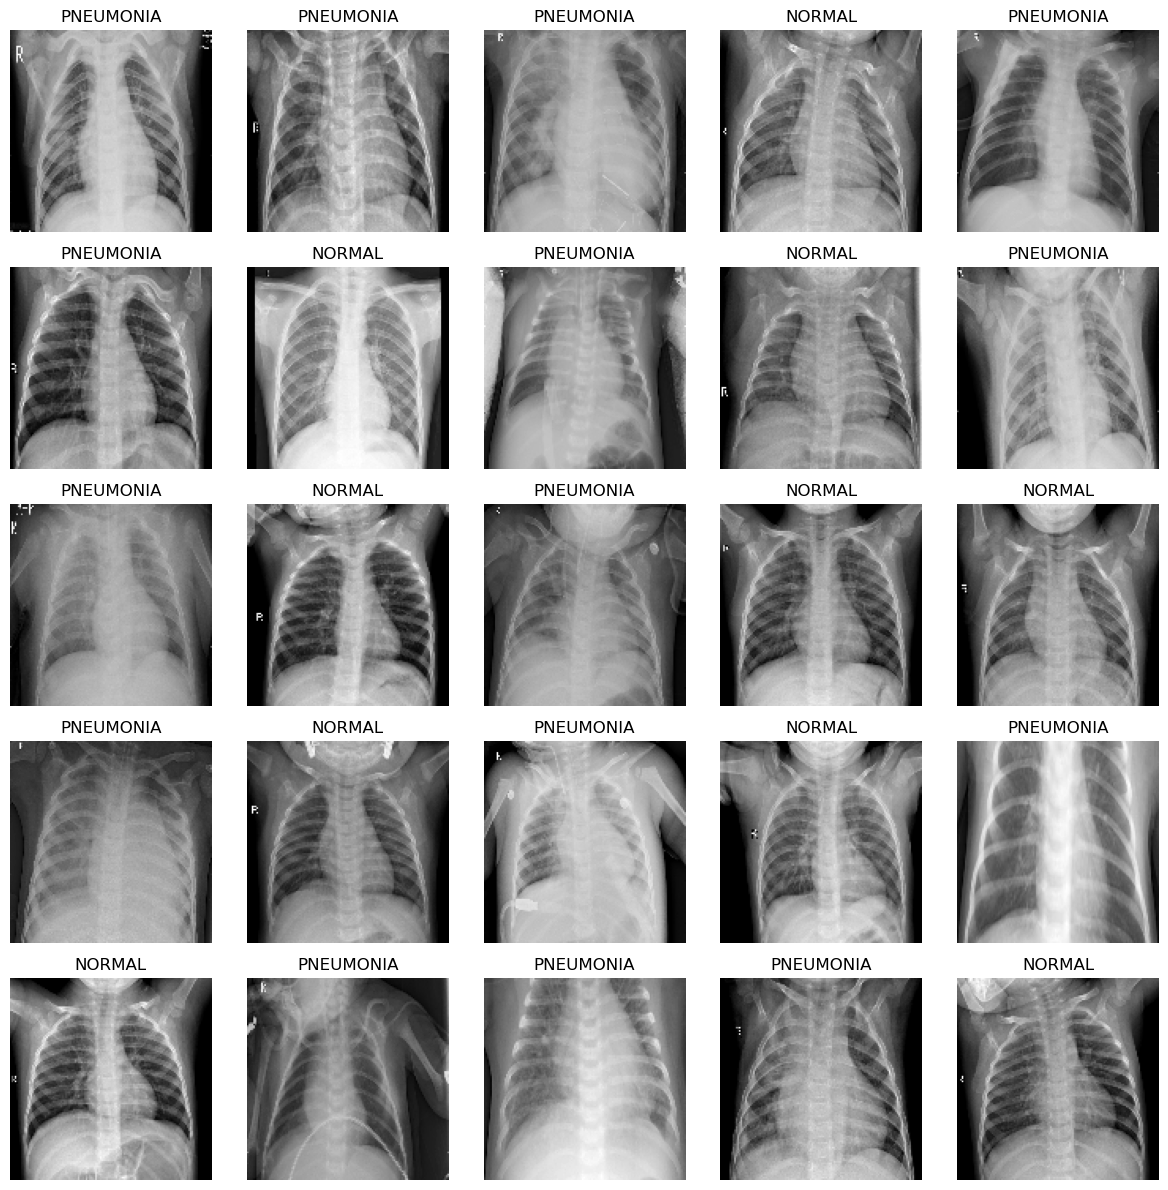

In [18]:

np.random.shuffle(data)

# Plotting some sample images
plt.figure(figsize=(12, 12))

for i in range(25):  # Displaying 25 images
    plt.subplot(5, 5, i + 1)
    plt.imshow(data[i][0], cmap='gray')
    plt.title(CATEGORIES[data[i][1]])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
#check if the data is balanced


unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))


{0: 4273, 1: 1583}


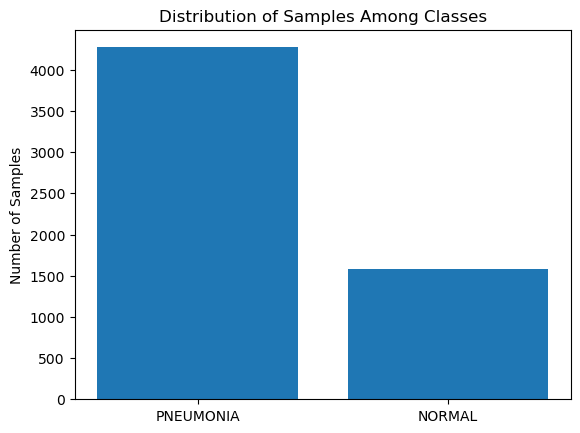

In [22]:


plt.bar(unique, counts)
plt.xticks(unique, [CATEGORIES[i] for i in unique])
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples Among Classes')
plt.show()


In [23]:
total_samples = len(y)
for i, count in zip(unique, counts):
    percent = (count / total_samples) * 100
    print(f"Class {CATEGORIES[i]}: {count} samples ({percent:.2f}%)")


Class PNEUMONIA: 4273 samples (72.97%)
Class NORMAL: 1583 samples (27.03%)


In [19]:
X = []
y = []

for features, label in data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)


In [20]:
print(X.shape)
print(y.shape)



(5856, 128, 128, 1)
(5856,)


In [24]:
#Data Normalization
#Normalize the pixel values to be between 0 and 1.
X = X / 255.0


In [27]:


datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images by up to 10 degrees
    zoom_range=0.1,  # randomly zoom images in and out by up to 10%
    width_shift_range=0.1,  # randomly shift images horizontally by up to 10% of their width
    height_shift_range=0.1,  # randomly shift images vertically by up to 10% of their height
    horizontal_flip=True,  # randomly flip images horizontally
    fill_mode='nearest'  # how to fill in newly created pixels
)


In [28]:
num_augmentations = 4273 - 1583  # number of augmentations required to balance the two classes

X_normal = np.array([x for x, label in zip(X, y) if label == CATEGORIES.index('NORMAL')])
augmented_images = []

i = 0
for batch in datagen.flow(X_normal, batch_size=32):
    augmented_images.extend(batch)
    i += len(batch)
    if i > num_augmentations:
        break

# Append augmented images and their labels to our dataset
X = np.concatenate((X, np.array(augmented_images)))
y = np.concatenate((y, [CATEGORIES.index('NORMAL')] * len(augmented_images)))


In [29]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
y = y[indices]


In [32]:
unique, counts = np.unique(y, return_counts=True)
print(dict(zip(unique, counts)))

{0: 4273, 1: 4286}


In [30]:
print(X.shape)
print(y.shape)

(8559, 128, 128, 1)
(8559,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(6847, 128, 128, 1)
(1712, 128, 128, 1)
(6847,)
(1712,)


# 2. CNN Model Building:

In [35]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [37]:

early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)


In [38]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop])


Epoch 1/50
193/193 [==============================] - 86s 448ms/step - loss: 0.1002 - accuracy: 0.9661 - val_loss: 0.0999 - val_accuracy: 0.9679
Epoch 2/50
193/193 [==============================] - 86s 445ms/step - loss: 0.0813 - accuracy: 0.9719 - val_loss: 0.0959 - val_accuracy: 0.9679
Epoch 3/50
193/193 [==============================] - 96s 496ms/step - loss: 0.0694 - accuracy: 0.9758 - val_loss: 0.1025 - val_accuracy: 0.9679
Epoch 4/50
193/193 [==============================] - 95s 491ms/step - loss: 0.0548 - accuracy: 0.9804 - val_loss: 0.0995 - val_accuracy: 0.9708
Epoch 5/50
193/193 [==============================] - 82s 425ms/step - loss: 0.0458 - accuracy: 0.9841 - val_loss: 0.0994 - val_accuracy: 0.9664
Epoch 5: early stopping


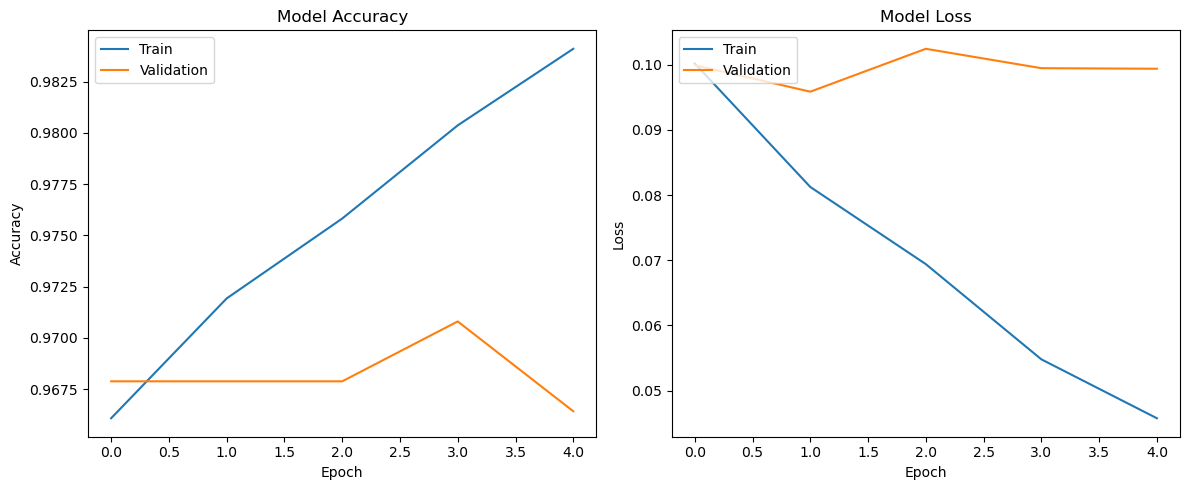

In [52]:


# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Plot for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot for loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [39]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


54/54 [==============================] - 3s 52ms/step - loss: 0.1154 - accuracy: 0.9597
Test accuracy: 0.9596962332725525


In [50]:


# Predicting the labels for the test set
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)  # Thresholding the prediction to get binary classification

# Printing the classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=CATEGORIES))

# Printing the confusion matrix
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_classes))


54/54 [==============================] - 3s 47ms/step
Classification Report:

              precision    recall  f1-score   support

   PNEUMONIA       0.98      0.94      0.96       840
      NORMAL       0.95      0.98      0.96       872

    accuracy                           0.96      1712
   macro avg       0.96      0.96      0.96      1712
weighted avg       0.96      0.96      0.96      1712

Confusion Matrix:

[[791  49]
 [ 20 852]]


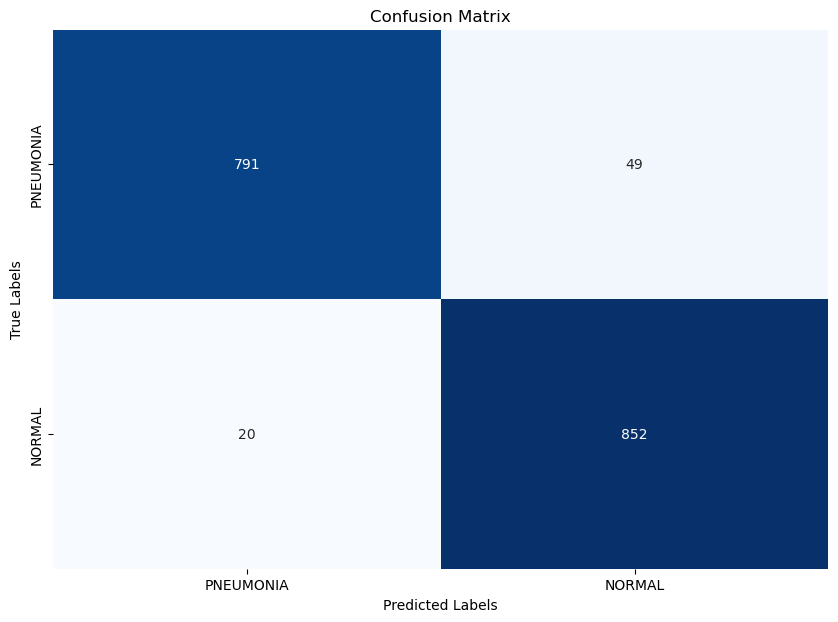

In [51]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 7))

# Using seaborn to plot it
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
            xticklabels=CATEGORIES, yticklabels=CATEGORIES)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [40]:
model.save('my_model.h5')


In [41]:
# Load the trained model
model = load_model('my_model.h5')

In [48]:

def predict_image():
    img_path = input("Please enter the path of the image: ")
    IMG_SIZE = 128  # 
    img_array = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img_array is None:
        print("Image not loaded. Please check the file path and try again.")
        return
    
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    normalized_array = resized_array / 255.0
    reshaped_array = normalized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
    
    prediction = model.predict(reshaped_array)
    predicted_class = CATEGORIES[int(np.round(prediction[0]))]
    
    print(f"The model predicts this image as: {predicted_class}")

# Call the function to test
predict_image()


Please enter the path of the image: person1_virus_8.jpeg
1/1 [==============================] - 0s 20ms/step
The model predicts this image as: PNEUMONIA


C:\Users\Khadi\AppData\Local\Temp\ipykernel_13584\2463822257.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_class = CATEGORIES[int(np.round(prediction[0]))]
